# Convex Optimization: Homework 3

In [1]:
%matplotlib widget
import numpy as np
from numpy.random import randn, uniform
import matplotlib.pyplot as plt
from tqdm import tqdm
np.random.seed(0)

## Utility functions

In [2]:
def f0(Q, p, v):
    return v@Q@v + p@v


def f(Q, p, A, b, t, v):
    in_log = (b - A@v)
    if np.any(in_log<0):
        return np.inf
    return t*(v@Q@v) + t*p@v - np.sum(np.log(in_log))


def grad_f(Q, p, A, b, t, v):
    denom = 1 / (b - (A@v)) # (2d,)
    return 2*t*(Q@v) + t*p + np.einsum('ij,i->j', A, denom)


def hess_f(Q, p, A, b, t, v):
    denom = 1 / (b - A @ v)**2 # (2p,)
    A_matrices = np.einsum('ij,ik->ijk', A, A) # (2d, n, n)
    sum_matrices = np.sum(denom[:,None,None] * A_matrices, axis=0) # (n, n)
    return 2*t*Q + sum_matrices

## 2.1.  Centering Step

In [3]:
def centering_step(Q, p, A, b, t, v0, eps):
    v_arr = [v0]
    v = v0.copy()
    
    grad = grad_f(Q, p, A, b, t, v) # (n,)
    H_inv = np.linalg.inv(hess_f(Q, p, A, b, t, v)) # (n, n) 
    delta_v = -H_inv @ grad
    lamb_2 = -grad@delta_v

    def back_line_search(delta_v, beta=0.9, alpha=0.1, max_iter=500):
        step = 1
        while f(Q, p, A, b, t, v + step*delta_v) > f(Q, p, A, b, t, v)-alpha*step*grad@delta_v:
            step *= beta
        return step
    
    while lamb_2/2  > eps:
        best_step = back_line_search(delta_v)
        v += best_step * delta_v
        v_arr.append(v)
        
        grad = grad_f(Q, p, A, b, t, v) # (n,)
        H_inv = np.linalg.inv(hess_f(Q, p, A, b, t, v)) # (n, n)
        lamb_2 = -grad @ delta_v
        delta_v = -H_inv @ grad

    return v_arr

## 2.2. Barrier Method

In [4]:
def barr_method(Q, p, A, b, v0, eps, mu):
    m = A.shape[0]
    v_arr = [v0]
    v = v0.copy()
    t = 1
    while  m/t >= eps:
        v_center = centering_step(Q, p, A, b, t, v, eps)
        v_arr+=v_center
        t *= mu
        v = v_center[-1]
    return np.array(v_arr)

## 3. Experiments

In [5]:
def init_params(n, d, l):
    """Utility function to initialize the problem"""
    
    X = np.random.normal(size=(n, d))
    Q = 0.5 * np.eye(n)
    p = np.random.normal(size=n) # =y
    A = np.vstack([X.T, -X.T])
    b = l * np.ones(2*d)
    v0 = np.random.normal(size=n)
    eps = 1e-7
    return Q, p, A, b, v0, eps

n = 10
d = 300
lamb = 10
Q, p, A, b, v0, eps = init_params(d, n, lamb)

In [6]:
all_v_arr = []
mu_vals = [5, 15, 50, 100, 500, 400, 2000, 5000]
for mu in tqdm(mu_vals):
    v_arr = barr_method(Q, p, A, b, v0, eps, mu)
    all_v_arr.append(v_arr)

100%|██████████| 8/8 [00:03<00:00,  2.64it/s]


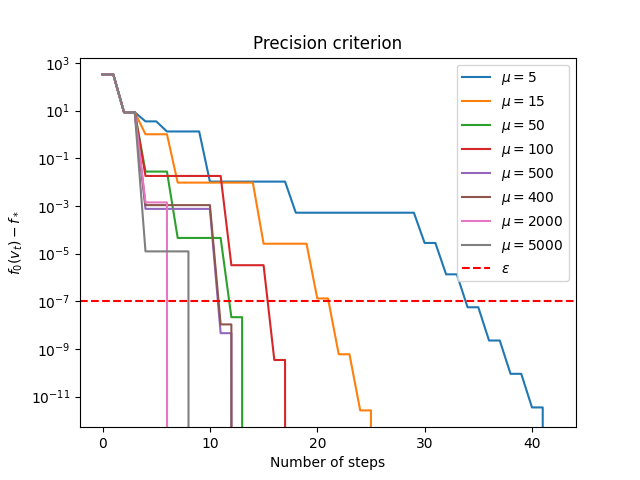

In [7]:
plt.figure()
plt.title('Precision criterion')
for mu, v_arr in zip(mu_vals, all_v_arr):
    f_vals = []
    for v in v_arr:
        f_vals.append(f0(Q, p, v))
    plt.plot(np.array(f_vals)-np.min(f_vals), label=f'$\mu=${mu}')
    plt.ylabel('$f_0(v_t)-f_*$')
    plt.xlabel('Number of steps')
    plt.yscale('log')
plt.axhline(eps, ls='--', c='r', label='$\epsilon$')
plt.legend()
plt.show()